In [2]:
!pip install -q git+https://github.com/forrestbao/pyeeg.git

## Python Packages

In [3]:
import os
import time
import math
import keras
import timeit
import warnings
import csv

import numpy as np
import pyeeg as pe
import pickle as pickle
import pandas as pd
import keras.backend as K
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, normalize
from tensorflow.keras.callbacks import Callback
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.optimizers import SGD
from keras.layers import (
    Dense, Conv1D, MaxPooling1D, 
    Conv2D, MaxPooling2D, Dropout,
    Flatten, Convolution1D, ZeroPadding1D, LSTM,
    BatchNormalization, Activation, Bidirectional
)

In [4]:
warnings.filterwarnings('ignore')

In [5]:
keras.utils.set_random_seed(0)

In [6]:
!mkdir /kaggle/working/data/
!mkdir /kaggle/working/data/data_training
!mkdir /kaggle/working/data/label_training
!mkdir /kaggle/working/data/data_testing
!mkdir /kaggle/working/data/label_testing

## Signal Parameters

In [7]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen
band = [4,8,12,16,25,45] #5 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03', '04', '05', '06']#List of subjects

## Signal Processing

In [8]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open("/kaggle/input/deap-dataset/data_preprocessed_python/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array, dtype=object))    
                start = start + step_size
                
        meta = np.array(meta)
        np.save('/kaggle/working/data/s' + sub, meta, allow_pickle=True, fix_imports=True)

In [9]:
for subjects in subjectList:
    FFT_Processing (subjects, channel, band, window_size, step_size, sample_rate)

In [10]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open('/kaggle/working/data/s' + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 4 == 0:
          data_testing.append(sub[i][0])
          label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          label_training.append(sub[i][1])

In [11]:
np.save('/kaggle/working/data/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('/kaggle/working/data/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('/kaggle/working/data/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('/kaggle/working/data/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (87840, 70) (87840, 4)
testing dataset: (29280, 70) (29280, 4)


In [12]:
with open('/kaggle/working/data/data_training.npy', 'rb') as fileTrain:
    X  = np.load(fileTrain)
    
with open('/kaggle/working/data/label_training.npy', 'rb') as fileTrainL:
    Y  = np.load(fileTrainL)
    
X = normalize(X)
Z = np.ravel(Y[:, [3]])

Arousal_Train = np.ravel(Y[:, [0]])
Valence_Train = np.ravel(Y[:, [1]])
Domain_Train = np.ravel(Y[:, [2]])
Like_Train = np.ravel(Y[:, [3]])

In [13]:
# Arousal and Valence
Z_arousal = np.ravel(Y[:, [0]])
Z_valence = np.ravel(Y[:, [1]])

Z_arousal_masked = (Z_arousal > 6.5).astype(int)
Z_valence_masked = (Z_valence > 6.5).astype(int)

In [14]:
y_train = np.array([Z_arousal_masked, Z_valence_masked]).T
y_train.shape

(87840, 2)

In [15]:
X.shape

(87840, 70)

In [16]:
x_train = np.array(X[:])

In [17]:
with open('/kaggle/working/data/data_testing.npy', 'rb') as fileTrain:
    M  = np.load(fileTrain)
    
with open('/kaggle/working/data/label_testing.npy', 'rb') as fileTrainL:
    N  = np.load(fileTrainL)

M = normalize(M)
L = np.ravel(N[:, [3]])

Arousal_Test = np.ravel(N[:, [0]])
Valence_Test = np.ravel(N[:, [1]])
Domain_Test = np.ravel(N[:, [2]])
Like_Test = np.ravel(N[:, [3]])

In [18]:
# Arousal and Valence
L_arousal = np.ravel(N[:, [0]])
L_valence = np.ravel(N[:, [1]])

L_arousal_masked = (L_arousal > 6.5).astype(int)
L_valence_masked = (L_valence > 6.5).astype(int)

In [19]:
y_test = np.array([L_arousal_masked, L_valence_masked]).T
y_test.shape

(29280, 2)

In [20]:
x_test = np.array(M[:])

## Feature Scaling

In [21]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

In [22]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)

In [23]:
x_train.shape

(87840, 70, 1)

In [24]:
x_test.shape

(29280, 70, 1)

In [25]:
batch_size = 256
num_classes = 2
epochs = 200
input_shape=(x_train.shape[1], 1)

In [26]:
input_shape

(70, 1)

## Model Logs 

In [27]:
csv_file = "bi_ltsm_model_log.csv" # This file will be used to save the model's evolution

In [28]:
headers = ["epoch", "loss", "accuracy", "val_loss", "val_accuracy"]

In [29]:
with open(csv_file, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(headers)

In [30]:
class CSVLoggerCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Append metrics to the CSV file at the end of each epoch
        with open(csv_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([
                epoch + 1,  # Epoch index starts from 0, so add 1 for readability
                logs["loss"],
                logs["accuracy"],
                logs["val_loss"],
                logs["val_accuracy"]
            ])

## Model Training

In [31]:
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape),
    Dropout(0.6),
    LSTM(units=256, return_sequences=True),
    Dropout(0.6),
    LSTM(units=64, return_sequences=True),
    Dropout(0.6),
    LSTM(units=64, return_sequences=True),
    Dropout(0.4),
    LSTM(units=32),
    Dropout(0.4),
    Dense(units=16),
    Activation('relu'),
    Dense(units=num_classes, activation='sigmoid')
])

In [32]:
model.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=["accuracy"])

In [33]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 70, 256)        │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 70, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 70, 256)        │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 70, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 70, 64)         │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 70, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 70, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 70, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 786,610 (3.00 MB)

 Trainable params: 786,610 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
m=model.fit(x_train, y_train,epochs=100,batch_size=256,verbose=1,validation_data=(x_test, y_test), callbacks=[CSVLoggerCallback()])

Epoch 1/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 28s 63ms/step - accuracy: 0.7171 - loss: 0.6045 - val_accuracy: 0.7054 - val_loss: 0.5711
Epoch 2/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.7145 - loss: 0.5703 - val_accuracy: 0.7093 - val_loss: 0.5622
Epoch 3/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.7174 - loss: 0.5661 - val_accuracy: 0.7761 - val_loss: 0.5620
Epoch 4/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.7251 - loss: 0.5638 - val_accuracy: 0.7164 - val_loss: 0.5590
Epoch 5/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.7273 - loss: 0.5592 - val_accuracy: 0.7493 - val_loss: 0.5509
Epoch 6/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.7327 - loss: 0.5541 - val_accuracy: 0.7221 - val_loss: 0.5572
Epoch 7/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.7445 - loss: 0.5529 - val_accuracy: 0.7750 - val_loss: 0.5442
Epoch 8/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.7578 - loss: 0

In [35]:
model.save('/kaggle/working/bi-lstm-model.h5')

In [36]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

915/915 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.8845 - loss: 0.1981
Test loss: 0.21268482506275177
Test accuracy: 0.91977459192276


## Performance Visualization

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


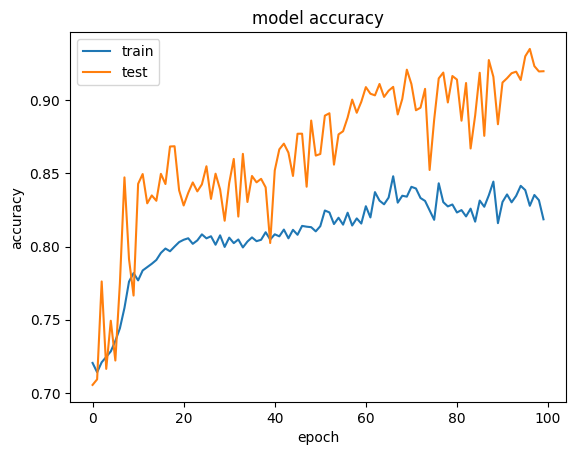

In [37]:
print(m.history.keys())
# summarize history for accuracy
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

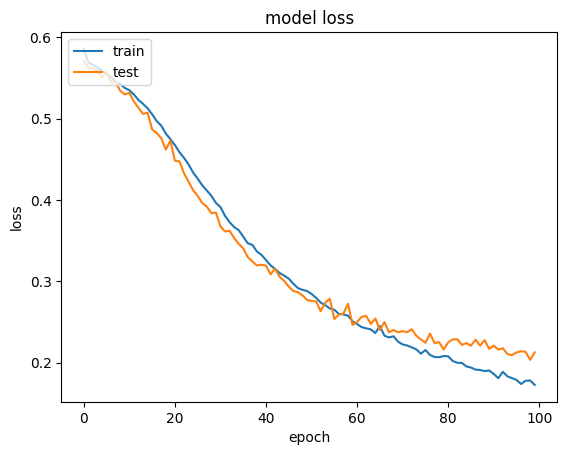

In [38]:
# summarize history for loss
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

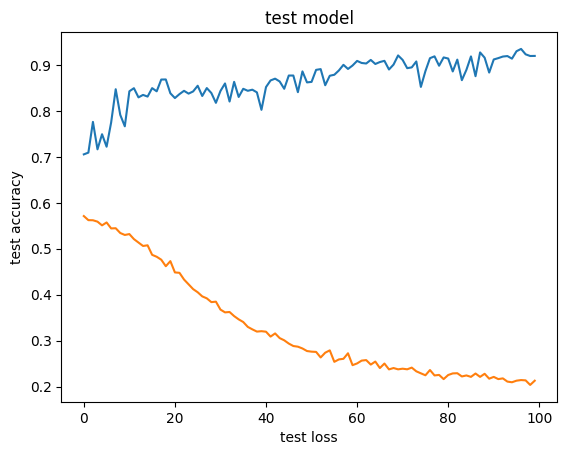

In [39]:
plt.plot(m.history['val_accuracy'])
plt.plot(m.history['val_loss'])
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')
plt.show()